### API for coordinates

In [1]:
import requests
import numpy as np
import pandas as pd
import json
import geopandas as gpd
import rioxarray
import rasterio
from rasterio import mask
import geojson
import matplotlib as plt
from matplotlib import pyplot as plt
import geopandas
from shapely.geometry import box
import georasters as gr
from osgeo import gdal
from rasterio.plot import show
import plotly.graph_objects as go
from shapely.geometry import Polygon
import shapefile
%matplotlib inline

In [2]:
address = "Wapper 9 2000 Antwerpen" 

In [3]:
def get_coordinates(address: str):
    req = requests.get(f"https://loc.geopunt.be/v4/Location?q={address}").json()
    info = {'address' : address, 
                'x_value' : req['LocationResult'][0]['Location']['X_Lambert72'],
                'y_value' : req['LocationResult'][0]['Location']['Y_Lambert72'],
                'street' : req['LocationResult'][0]['Thoroughfarename'],
                'house_number' : req['LocationResult'][0]['Housenumber'], 
                'postcode': req['LocationResult'][0]['Zipcode'], 
                'municipality' : req['LocationResult'][0]['Municipality']}
    
    detail = requests.get("https://api.basisregisters.vlaanderen.be/v1/adresmatch", 
                          params={"postcode": info['postcode'], 
                                  "straatnaam": info['street'],
                                  "huisnummer": info['house_number']}).json()
    building = requests.get(detail['adresMatches'][0]['adresseerbareObjecten'][0]['detail']).json()
    build = requests.get(building['gebouw']['detail']).json()
    info['polygon'] = [build['geometriePolygoon']['polygon']["coordinates"]]
    return info
info = get_coordinates(address)
#info

# X & Y are the longitude and latitude
#X = left & right, greater than the left and less than the right
# Y  = top & bottom , greater than bottom , less than top

### Find coordinates in CSV bounds

In [4]:
path = "ALL_BOUNDS.csv"
bounds = pd.read_csv(path) 

### For DSM

In [5]:
#X = left & right, greater than the left and less than the right
# Y  = top & bottom , greater than bottom , less than top

def find_coordinates_DSM():
    x = info["x_value"]
    y = info["y_value"]
    for num in range (0, 42+1):
        left_bounds = bounds.left[num]
        right_bounds = bounds.right[num]
        top_bounds = bounds.top[num]
        bottom_bounds = bounds.bottom[num]
        
        if x >= left_bounds and x <= right_bounds and y <= top_bounds and y >= bottom_bounds:
            DSM_tif = "Data/DSM/DSM-"+str(num+1)+"/GeoTIFF/DHMVIIDSMRAS1m_k"+("0" if num <= 8 else "")+str(num+1)+".tif"
            return DSM_tif
    
DSM_tif = find_coordinates_DSM()

### For DTM

In [6]:
#X = left & right, greater than the left and less than the right
# Y  = top & bottom , greater than bottom , less than top

def find_coordinates_DTM():
    x = info["x_value"]
    y = info["y_value"]
    
    for num in range (0, 42+1):
        left_bounds = bounds.left[num]
        right_bounds = bounds.right[num]
        top_bounds = bounds.top[num]
        bottom_bounds = bounds.bottom[num]
        
        if x >= left_bounds and x <= right_bounds and y <= top_bounds and y >= bottom_bounds:
            DTM_tif = "Data/DTM/DTM-"+str(num+1)+"/GeoTIFF/DHMVIIDTMRAS1m_k"+("0" if num <= 8 else "")+str(num+1)+".tif"
            return DTM_tif
            
            
DTM_tif = find_coordinates_DTM()

In [7]:
bounds.left[1]

162000.0

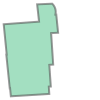

In [8]:
polygon = info["polygon"]
def polygon_shape():
    polygon_shapely = Polygon(polygon[0][0])
    return polygon_shapely
polygon_shape()

In [9]:
def polygon_bounds():
    x_polygon = [x[0] for x in polygon[0][0]]
    y_polygon = [x[1] for x in polygon[0][0]]
    x_left = min(x_polygon)
    x_right = max(x_polygon)
    y_bottom = min(y_polygon)
    y_top = max(y_polygon)
    return (x_left, x_right, y_bottom, y_top)
    
polygon_bounds()

(152823.13902120292, 152849.52583722025, 211882.7860690616, 211927.70728509128)

### Make shapefile, clip & plot (other way)

In [10]:
def make_shapefile():
    write = shapefile.Writer("shapefiles/test/polygon")
    write.field("name", "C")
    write.poly([polygon[0][0]])
    write.record("polygon_1")
    write.close()
    
make_shapefile()

In [11]:
polygon_path = "/home/becode/3D-House/3D-House-Project/shapefiles/test/polygon.shp"

Warning 1: the source raster dataset has a SRS, but the cutline features
not.  We assume that the cutline coordinates are expressed in the destination SRS.
If not, cutline results may be incorrect.


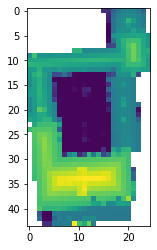

In [12]:
#DSM clip

def clip_DSM():
    OutTile = gdal.Warp("/home/becode/3D-House/3D-House-Project/shapefiles/test/DSM_clip2.tif", 
                    DSM_tif, 
                    cutlineDSName=polygon_path,
                    cropToCutline=True,
                    dstNodata = 0)
    OutTile = None 
    DSM_clip = rioxarray.open_rasterio("/home/becode/3D-House/3D-House-Project/shapefiles/test/DSM_clip2.tif", masked = True)
    show(DSM_clip)
    return DSM_clip
    
DSM_clip = clip_DSM()

Warning 1: the source raster dataset has a SRS, but the cutline features
not.  We assume that the cutline coordinates are expressed in the destination SRS.
If not, cutline results may be incorrect.


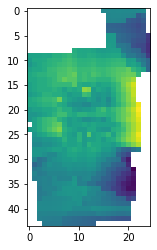

In [13]:
def clip_DTM():
    OutTile_2 = gdal.Warp("/home/becode/3D-House/3D-House-Project/shapefiles/test/DTM_clip2.tif", 
                          DTM_tif, 
                          cutlineDSName=polygon_path,
                          cropToCutline=True,
                          dstNodata = 0)
    OutTile_2 = None 
    DTM_clip = rioxarray.open_rasterio("/home/becode/3D-House/3D-House-Project/shapefiles/test/DTM_clip2.tif", masked = True)
    show(DTM_clip)
    return DTM_clip

DTM_clip = clip_DTM()

In [14]:
image = DSM_clip - DTM_clip

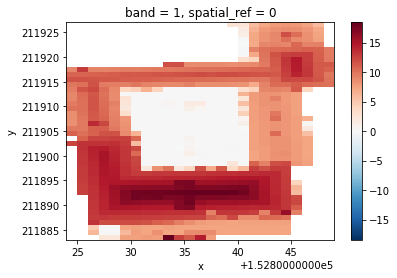

In [15]:
image.plot()

In [16]:
#image before, gotta change the nan into zero
#image

In [17]:
# Turn NaN into zeros
def clean_image():
    new_image = np.where(np.isnan(image), 0, image)
    #print(new_image)
    image_2 = np.pad(new_image[0], pad_width = 1, mode ="constant", constant_values = 0)
    print(image_2)
    return image_2
image_2 = clean_image()

[[0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 5.8365264 0.        0.       ]
 [0.        0.        0.        ... 7.0774727 0.        0.       ]
 ...
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]]


In [18]:
image_2.shape

(46, 27)

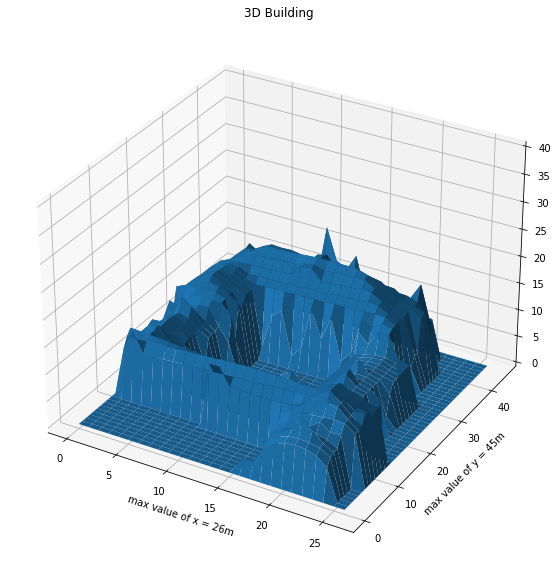

In [66]:
def show_imageshape():
    ab = image_2.shape[0]
    ac = image_2.shape[1]
    x, y = np.meshgrid(np.arange(ac), np.arange(ab))
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(projection="3d")
    ax.plot_surface(x, y, image_2)
    ax.set_zlim(0, 40)
    plt.title("3D Building")
    plt.xlabel(f"max value of x = {x.max()}m")
    plt.ylabel(f"max value of y = {y.max()}m")
    #plt.(f"height of building = {image_2.max()}m")
    #plt.legend(f"area = {x.max()*y.max()}")
    plt.show()
    fig = go.Figure(data=[go.Surface(z=image_2, x=x, y=y)])
   
    #plt.text(40, 40, "text", fontsize=14)
    #fig.xlabel("")
    fig.show()

show_imageshape()

In [20]:

#def final_image():
#    fig = go.Figure(data=[go.Surface(z=image_2, x=x, y=y)])
#    fig.show()
#final_image()
#
# z = height
# x and y are coordinates (latitude & longitude)

In [21]:
pwd

'/home/becode/3D-House/3D-House-Project'

In [22]:
# height
# area of plot
# how many floors & if it has pools 

In [23]:
polygon[0]

[[[152848.34298922122, 211923.13147708774],
  [152848.3735812232, 211923.8464850895],
  [152848.30945321918, 211924.5717330873],
  [152848.14855722338, 211925.2886610888],
  [152847.89383722097, 211925.97768509015],
  [152847.5532292202, 211926.62126909196],
  [152847.13876522332, 211927.2045650892],
  [152846.66567721963, 211927.70728509128],
  [152840.19214121252, 211927.42632509023],
  [152839.35655721277, 211927.3900370896],
  [152840.29057321697, 211919.00290108472],
  [152823.13902120292, 211917.73800508305],
  [152824.59700520337, 211903.0239570737],
  [152824.40007720888, 211903.01096507534],
  [152826.07303720713, 211886.6471250616],
  [152826.22791720927, 211886.6861010641],
  [152826.6129412055, 211882.7860690616],
  [152845.24935721606, 211883.92834106088],
  [152845.02522922307, 211887.4845650643],
  [152845.99092522264, 211887.5262290649],
  [152845.26689322293, 211898.0402130708],
  [152847.13991722465, 211898.1703890711],
  [152846.14932522178, 211913.44322108105],
  [1

<AxesSubplot:>

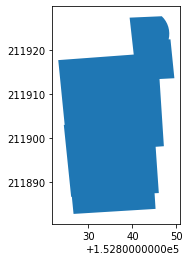

In [24]:
# Read test file

path = "/home/becode/3D-House/3D-House-Project/shapefiles/test/polygon.shp"
test = gpd.read_file(path)
test.plot()

In [25]:

#geometries = [{"Type": "Polygon", "Coordinate Points": polygon}]
#xds = rioxarray.open_rasterio(
#"Data/DSM/DSM-1/GeoTIFF/DHMVIIDSMRAS1m_k01.tif", masked = True).rio.clip(geometries, from_disk=True)

In [26]:
#geometries = {"type": "Polygon", "coordinates": [polygon]}
#xds = rioxarray.open_rasterio(
#    "Data/DSM/DSM-1/GeoTIFF/DHMVIIDSMRAS1m_k01.tif", masked = True)
#print(type(xds))

In [27]:
#type(geometries)

In [28]:

#cropping_geometries = [geojson.loads(geometries.content.decode("utf-8"))]
##json.loads(myResponse.content.decode('utf-8'))
#print(type(cropping_geometries))
##xds.rio.clip(geometries=cropping_geometries, from_disk=True)



In [29]:
#"""
#geometry = ''' {"type": "Polygon",
#    ...                 "coordinates": [
#    ...                 [[-94.07955380199459, 41.69085871273774],
#    ...                 [-94.06082436942204, 41.69103313774798],
#    ...                 [-94.06063203899649, 41.67932439500822],
#    ...                 [-94.07935807746362, 41.679150041277325],
#    ...                 [-94.07955380199459, 41.69085871273774]]]}'''
#    >>> cropping_geometries = [geojson.loads(geometry)]
#    >>> xds = xarray.open_rasterio('cool_raster.tif')
#    >>> cropped = xds.rio.clip(geometries=cropping_geometries, crs=4326)
#